# Clumpiness measures

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from collections import defaultdict
from itertools import product

import geopandas as gpd
import numpy as np
import pandas as pd
from itrx import Itr
from shapely import Polygon

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit, normalised_clumpiness
from utils import CATEGORIES, Month, load_crime_data, monthgen

In [ ]:
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "GRID"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 200.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
# AREA_THRESHOLDS = [0.5, 0.25, 0.1]

In [ ]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = load_crime_data(
    FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(36), filters={"Crime type": CATEGORY}
)
# remove any points outside boundary
raw_crime_data = raw_crime_data.sjoin(force_boundary)
raw_crime_data

### Clumpiness index (CI)



In [45]:
def squares(nx: int, ny: int, length: float) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(
        geometry=[
            Polygon(
                [
                    (ix * length, iy * length),
                    ((ix + 1) * length, iy * length),
                    ((ix + 1) * length, (iy + 1) * length),
                    (ix * length, (iy + 1) * length),
                ]
            )
            for ix in range(nx)
            for iy in range(ny)
        ],
        crs="epsg:27700",
    )


def clumpiness_index(features: gpd.GeoDataFrame, total_area: float) -> float:
    external = features.union_all().length
    # each internal line is double-counted
    internal = (features.geometry.length.sum() - external) / 2

    g1 = internal / (internal + external)
    p1 = features.area.sum() / total_area

    # print(internal, external)
    # print(g1, p1)

    # Adepeju paper seems to be wrong
    # FRAGSTATS also seems dodgy
    # https://fragstats.org/index.php/fragstats-metrics/patch-based-metrics/aggregation-metrics/c4-clumpiness-index
    # If the proportion of like adjacencies (Gi) is greater than or equal to the proportion of the landscape comprised
    # of the focal class (Pi), then CLUMPY equals Gi minus Pi, divided by 1 minus Pi.
    # Likewise, if Gi < Pi, and Pi ≥ 0.5, then CLUMPY equals Gi minus Pi, divided by 1 minus Pi.
    # However, if Gi < Pi, and Pi < 0.5, then CLUMPY equals Pi minus Gi, divided by negative Pi.

    if g1 >= p1 or (p1 >= 0.5 and g1 < p1):
        return (g1 - p1) / (1 - p1)
    elif g1 < p1 and p1 < 0.5:
        return (g1 - p1) / p1
    else:
        return -1000

## Clumpiness measure

Requirements:
- essential:
    1. scale invariant (dimensionless quantity)
    2. intuitive scale with known bounds, e.g. 0 for completely dispersed, 1 for a single cluster with minimal perimeter  

- desirable:

    3. agnostic to shape of (regular) geometry
    4. works with irregular geometries (e.g. census geographies)

FRAGSTATS CI described by Adepeju does satisfies only one of these requirements. It is also poorly documented and
"hacky" and (potentially) discontinuous. The index value is impacted by the size of the background

Simple area/perimeter ratio is not scale invariant, nor is it intuitive.

But scale is integral to this - consider two disjoint squares of side $x$. At a length scale of $x$ this is a completely 
dispersed arrangement and a "clumpiness" value of 0 would be appropriate. However at a scale of $x/2$ this arrangement 
is two clusters of 4 squares and is thus to some degree clumpy. As the spatial scale decreased this arrangement must be 
considered to be more and more clumped.

Conversely applying a large length scale (say $10x$) on this arrangement becomes somewhat meaningless, so it is 
important that the length scale roughly represents a characteristic scale of the geometry.

Thus a length scale must be supplied to any unambiguous clumpiness calculation, and it can also be used to render 
quantities dimensionless, although in our case

To this end we compute upper and lower bounds, in units of the length scale $s$, for a square-based geometry with a 
given area $A$. The lower bound corresponds to length-unit squares arranged into a larger square:

$$
P_{min} = 4\sqrt{A}
$$

and the upper bound corresponds to $N=A/s^2$ disjoint length-unit squares:

$$
P_{max} = 4sN = \frac{4A}{s} 
$$

The clumpiness - the perimeter of the geometry in question - must then lie in between these two values (assuming a 
valid length scale has been chosen) and can be normalised:

$$
CI = \frac{P_{max} - P}{P_{max} - P_{min}}
$$

thus yielding a value of 0 for fully disjoint geometries (at the given length scale) and 1 for a geometry that minimises 
the perimeter (a square in this case)

0.3506261180679785
0.842389877887345


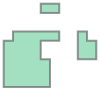

In [46]:
# Compare with FRAGSTATS measure

# Example from the Adepeju paper - our impl produces the value in the paper
f = squares(12, 11, 1).loc[
    [
        12,
        13,
        14,
        15,
        16,
        23,
        24,
        25,
        26,
        27,
        28,
        34,
        35,
        36,
        37,
        38,
        39,
        45,
        46,
        47,
        48,
        49,
        50,
        56,
        57,
        58,
        61,
        64,
        72,
        75,
        103,
        104,
        105,
        114,
        115,
    ]
]
print(clumpiness_index(f, 1 * 1 * 11 * 11))
print(normalised_clumpiness(f, 1))
# length = 100.0
f.geometry.union_all()

0.0


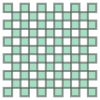

In [49]:
n = 11
g = squares(n, n, 1)[::2].geometry
# print(clumpiness_index(g, n * n))
print(normalised_clumpiness(g, 1.0))
g.union_all()

<Axes: >

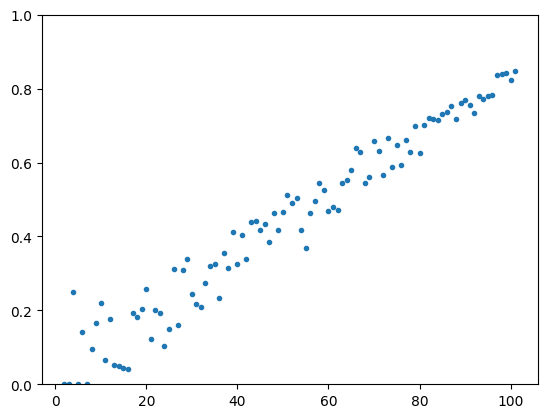

In [53]:
# randomly sample increasing number of squares
g = squares(n, n, 1)
# g = pd.concat([g[::2], g[1::2]])
s = pd.Series({i: normalised_clumpiness(g.sample(i), 1) for i in range(2, 102)})
s.plot(ylim=(0, 1), ls=" ", marker=".")

<Axes: xlabel='Squares filled in', ylabel='Clumpiness Index'>

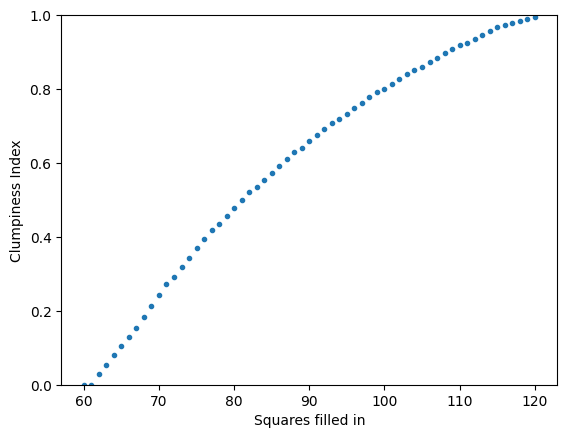

In [54]:
# start with fully dispersed and gradually fill in gaps
g2 = pd.concat([g[::2], g[1::2]])
s = pd.Series({i: normalised_clumpiness(g2[:i], 1.0) for i in range(len(g) // 2, len(g))})
s.plot(ylim=(0, 1), ls=" ", marker=".", xlabel="Squares filled in", ylabel="Clumpiness Index")

### Real Data

In [55]:
# some real data
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])
count_data = crime_data.groupby(["spatial_unit", "Month"])["Crime type"].count().unstack(level="Month").fillna(0)
count_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
spatial_unit,,,,,,,,,,,,,,,,,,,,,
1870,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,2.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
2120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77859,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
78104,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [88]:
top_frac = 0.1


def top(counts: pd.Series, frac: float):
    s = counts.sort_values().cumsum() / counts.sum()
    return s[s >= 1 - frac]


features.join(top(count_data["2025-05"], top_frac), how="right").explore("2025-05", tiles="CartoDB Positron")

## Temporal variability

No strong signs of the seasonality detected in other measures unless considering all crime

Smaller fractions are less clumpy

"Top %" refers to the smallest set of spatial units that contain that proportion of crime, i.e the most crime-ridden spatial units

<Axes: title={'center': 'Temporal variation of Clumpiness Index\nWest Yorkshire Anti-social behaviour'}, xlabel='Month', ylabel='Clumpiness Index'>

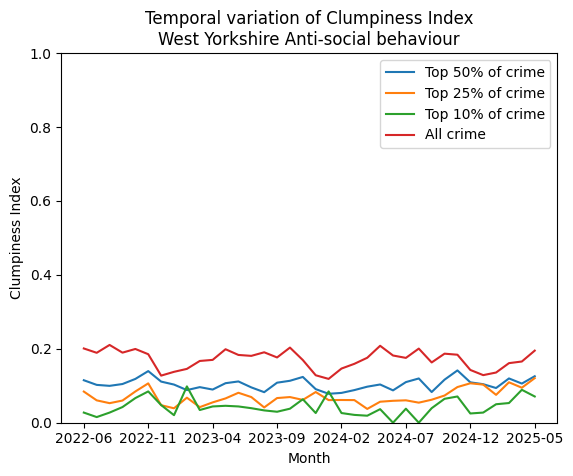

In [99]:
fracs = [0.5, 0.25, 0.1]
scale = np.sqrt(features.area.mean())
# compute clumpiness variation over time - strong seasonal variation
clumpiness = pd.DataFrame(index=count_data.columns, columns=[f"Top {f:.0%} of crime" for f in fracs])
for m in clumpiness.index:
    for f in fracs:
        counts = top(count_data[m], f)
        clumps = features.join(counts, how="right")
        clumpiness.loc[m, f"Top {f:.0%} of crime"] = normalised_clumpiness(clumps, scale)
    # all crime (just drop zeros)
    counts = count_data[m]
    clumps = features.join(counts[counts > 0], how="right")
    clumpiness.loc[m, "All crime"] = normalised_clumpiness(clumps, scale)

clumpiness.plot(
    ylim=(0, 1), ylabel="Clumpiness Index", title=f"Temporal variation of Clumpiness Index\n{FORCE} {CATEGORY}"
)

## Spatial variability



<Axes: title={'center': 'Spatial variation of Clumpiness Index\nWest Yorkshire Anti-social behaviour 2025-05'}, xlabel='Square grid length (m)', ylabel='Clumpiness Index'>

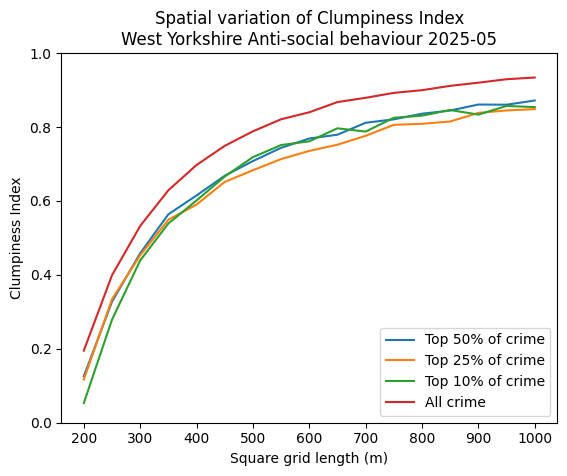

In [107]:
AREA = "GRID"
SIZES = np.arange(200.0, 1000.1, 50.0)

crime_data1m = raw_crime_data[raw_crime_data.Month == str(LATEST_DATE)]

clumpiness = pd.DataFrame(index=SIZES, columns=[f"Top {f:.0%} of crime" for f in fracs])

for size in clumpiness.index:
    crime_data, features = map_to_spatial_unit(crime_data1m, force_boundary, AREA, size=size)
    count_data = crime_data.groupby(["spatial_unit"])["Crime type"].count().rename("count")

    for f in fracs:
        counts = top(count_data, f)
        clumps = features.join(counts, how="right")
        clumpiness.loc[size, f"Top {f:.0%} of crime"] = normalised_clumpiness(clumps, scale)

    clumps = features.join(count_data[count_data != 0], how="right")
    clumpiness.loc[size, "All crime"] = normalised_clumpiness(clumps, scale)


clumpiness.plot(
    ylim=(0, 1),
    xlabel="Square grid length (m)",
    ylabel="Clumpiness Index",
    title=f"Spatial variation of Clumpiness Index\n{FORCE} {CATEGORY} {LATEST_DATE}",
)

## Spatial stability

How does offsetting a regular grid affect clumpiness index?

<Axes: >

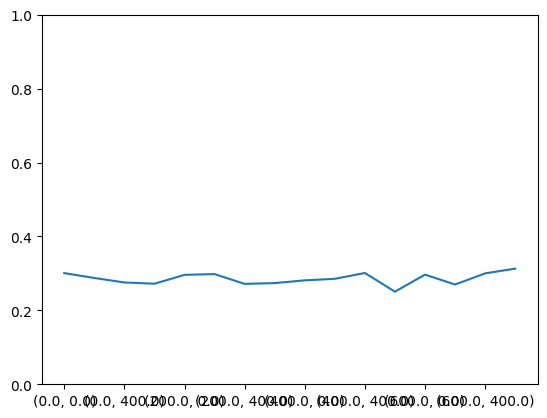

In [113]:
AREA = "GRID"
SIZE = 800.0

OFFSETS = tuple(product((0, SIZE / 4, SIZE / 2, 3 * SIZE / 4), (0, SIZE / 4, SIZE / 2, 3 * SIZE / 4)))

crime_data1m = raw_crime_data[raw_crime_data.Month == "2025-05"]

clumpiness = pd.Series(index=OFFSETS)

for offset in clumpiness.index:
    crime_data, features = map_to_spatial_unit(crime_data1m, force_boundary, AREA, size=SIZE, offset=offset)
    count_data = crime_data.groupby(["spatial_unit"])["Crime type"].count().rename("count")
    # features making up 50% of crime
    counts = top(count_data, 0.5)
    clumps = features.join(counts, how="right")
    clumpiness.loc[offset] = normalised_clumpiness(clumps, SIZE)

clumpiness.plot(ylim=(0, 1))

In [111]:
clumpiness

0.0    0.0      0.125789
       50.0     0.125231
       100.0    0.147666
       150.0    0.128788
50.0   0.0      0.127706
       50.0     0.127161
       100.0    0.126329
       150.0    0.133446
100.0  0.0      0.121727
       50.0     0.126343
       100.0    0.118972
       150.0    0.136076
150.0  0.0      0.103913
       50.0     0.122508
       100.0    0.140396
       150.0    0.125807
dtype: float64